In [27]:
import segyio
import numpy as np
import matplotlib.pyplot as plt
import pylops

In [28]:
# Data
itmin = 600 # index of first time/depth sample in data used in colored inversion
itmax = 800 # number of samples of statistical wavelet

# Subsampling (can save file at the end only without subsampling)
jt = 1
jil = 1
jxl = 1



# Trace-by-Trace Inversion
epsI_tt = 1e-3 # damping

# Spatially simultaneous
niter_sr = 3 # number of iterations of lsqr
epsI_sr = 1e-4 # damping
epsR_sr = 1e2 # spatial regularization

# Blocky simultaneous
niter_out_b = 3 # number of outer loop iterations
niter_in_b = 1 # number of inner loop iterations
niter_b = 10 # number of iterations of lsqr
mu_b = 1e-1 # damping for data term
epsI_b = 1e-4 # damping
epsR_b = 0.1 # spatial regularization
epsRL1_b = 0.2 # blocky regularization

In [29]:
#Loading seismic using Segyio lib

# string containing the path location of the seismic data at disk
segy_file_path = '..\seismic_volumes\DSMF_R0264_LIBRA_RTM_Time_SubVol.sgy'    #<-----------------Nome e caminho para a sismica

#loading stack using Segyio lib
stack = segyio.open(segy_file_path,iline=189, #<-----------------Byte da Inline
                xline=193) #<-----------------Byte da Cross
#Allocating IL, XL, Time axis in variables
il, xl, t = stack.ilines, stack.xlines, stack.samples
#Measuring Sample rate from data samples
dt = t[1] - t[0]
#Creating seismic cube format using segyio cube method
data_cube = segyio.cube(stack)
#Qc of the axis shapes
nil, nxl, nt = data_cube.shape

# Inlines information
il_start, il_end = il[0], il[-1]
    
# Crosslines information
xl_start, xl_end = xl[0], xl[-1]

In [8]:
'''f = segyio.open(segy_file_path, ignore_geometry=True)

traces = segyio.collect(f.trace)[:]
traces = traces[:, itmin:itmax]
ntraces, nt = traces.shape

t = f.samples[itmin:itmax]
il = f.attributes(segyio.TraceField.INLINE_3D)[:]
xl = f.attributes(segyio.TraceField.CROSSLINE_3D)[:]

# Define regular IL and XL axes
il_unique = np.unique(il)
xl_unique = np.unique(xl)

il_min, il_max = min(il_unique), max(il_unique)
xl_min, xl_max = min(xl_unique), max(xl_unique)

dt = t[1] - t[0]
dil = min(np.unique(np.diff(il_unique)))
dxl = min(np.unique(np.diff(xl_unique)))

ilines = np.arange(il_min, il_max + dil, dil)
xlines = np.arange(xl_min, xl_max + dxl, dxl)
nil, nxl = ilines.size, xlines.size

ilgrid, xlgrid = np.meshgrid(np.arange(nil),
                             np.arange(nxl),
                             indexing='ij')

# Look-up table
traces_indeces = np.full((nil, nxl), np.nan)
iils = (il - il_min) // dil
ixls = (xl - xl_min) // dxl
traces_indeces[iils, ixls] = np.arange(ntraces)
traces_available = np.logical_not(np.isnan(traces_indeces))

# Reorganize traces in regular grid
d = np.zeros((nil, nxl, nt))
d[ilgrid.ravel()[traces_available.ravel()],
  xlgrid.ravel()[traces_available.ravel()]] = traces

# Subsample
d = d[::jil, ::jxl, ::jt]
ilines = ilines[::jil]
xlines = xlines[::jxl]
t = t[::jt]
nil, nxl, nt = len(ilines), len(xlines), len(t)'''


"f = segyio.open(segy_file_path, ignore_geometry=True)\n\ntraces = segyio.collect(f.trace)[:]\ntraces = traces[:, itmin:itmax]\nntraces, nt = traces.shape\n\nt = f.samples[itmin:itmax]\nil = f.attributes(segyio.TraceField.INLINE_3D)[:]\nxl = f.attributes(segyio.TraceField.CROSSLINE_3D)[:]\n\n# Define regular IL and XL axes\nil_unique = np.unique(il)\nxl_unique = np.unique(xl)\n\nil_min, il_max = min(il_unique), max(il_unique)\nxl_min, xl_max = min(xl_unique), max(xl_unique)\n\ndt = t[1] - t[0]\ndil = min(np.unique(np.diff(il_unique)))\ndxl = min(np.unique(np.diff(xl_unique)))\n\nilines = np.arange(il_min, il_max + dil, dil)\nxlines = np.arange(xl_min, xl_max + dxl, dxl)\nnil, nxl = ilines.size, xlines.size\n\nilgrid, xlgrid = np.meshgrid(np.arange(nil),\n                             np.arange(nxl),\n                             indexing='ij')\n\n# Look-up table\ntraces_indeces = np.full((nil, nxl), np.nan)\niils = (il - il_min) // dil\nixls = (xl - xl_min) // dxl\ntraces_indeces[iils, 

In [30]:
print(nil, nxl, nt, dt)

845 801 2041 4.0


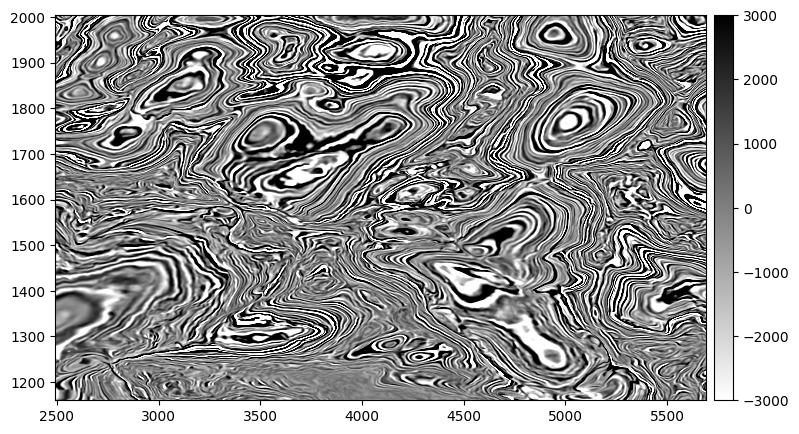

In [31]:
#plotting data
fig, ax = plt.subplots(figsize=(10, 5))
c=ax.imshow(data_cube[..., 1000].T, aspect='auto', cmap='gray_r', vmin=-3000, vmax=3000,
            extent=[xl_start, xl_end, il_start, il_end])


plt.colorbar(c, ax=ax, pad=0.01)
#ax.set_xlim(4000, 7000)
plt.grid(False)
#ax.set_ylim(6000, 4500)

(6000.0, 4500.0)

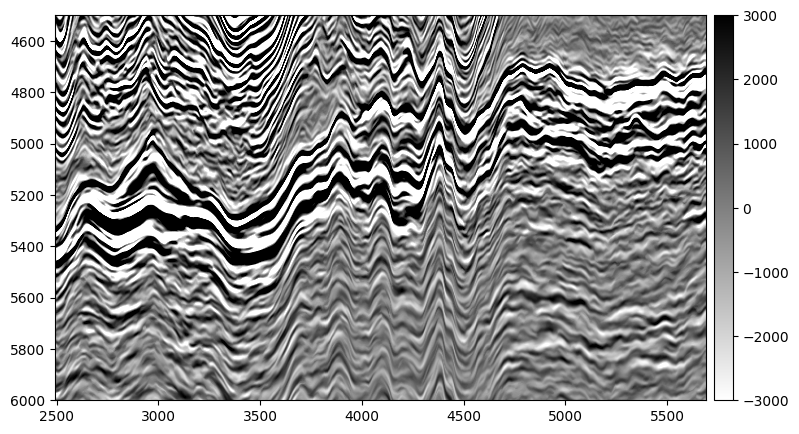

In [32]:
#plotting data
fig, ax = plt.subplots(figsize=(10, 5))
c=ax.imshow(data_cube[1600-il_start, :, :].T, aspect='auto', cmap='gray_r', vmin=-3000, vmax=3000,
            extent=[xl_start, xl_end, t[-1], t[0]])


plt.colorbar(c, ax=ax, pad=0.01)
#ax.set_xlim(4000, 7000)
plt.grid(False)
ax.set_ylim(6000, 4500)

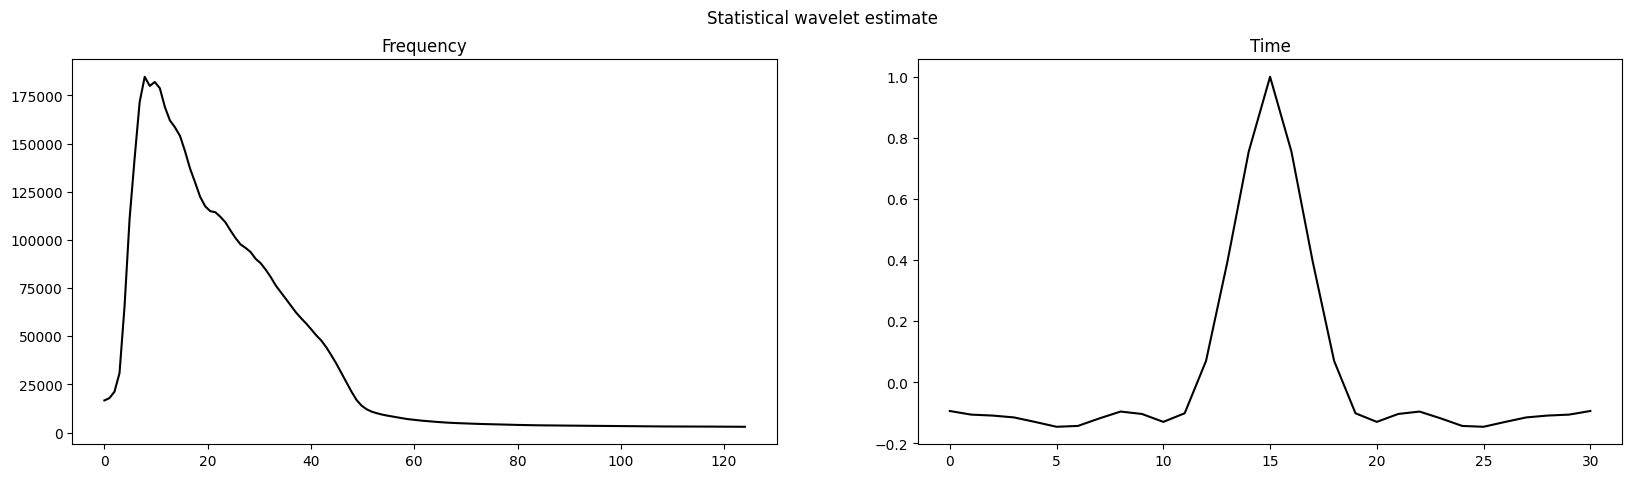

In [33]:
#Another wavelet estimation method

nt_wav = 16 # lenght of wavelet in samples
nfft = 2**8 # lenght of fft

# time axis for wavelet
t_wav = np.arange(nt_wav) * (dt/1000) 
t_wav = np.concatenate((np.flipud(-t_wav[1:]), t_wav), axis=0)

# estimate wavelet spectrum
wav_est_fft = np.mean(np.abs(np.fft.fft(data_cube[..., int(4600/dt):int(5600/dt)], nfft, axis=-1)), axis=(0, 1))#<-----------------Janela da FFT em indice
fwest = np.fft.fftfreq(nfft, d=dt/1000)

# create wavelet in time
wav_est = np.real(np.fft.ifft(wav_est_fft)[:nt_wav])
wav_est = np.concatenate((np.flipud(wav_est[1:]), wav_est), axis=0)
wav_est = wav_est / wav_est.max()
wcenter = np.argmax(np.abs(wav_est))

# display wavelet
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Statistical wavelet estimate')
axs[0].plot(fwest[:nfft//2], wav_est_fft[:nfft//2], 'k')
axs[0].set_title('Frequency')
axs[1].plot(wav_est, 'k')
axs[1].set_title('Time');

In [20]:
# swap time axis to first dimension
d_small = data_cube[..., int(4600/dt):int(5600/dt)]
d_small = np.swapaxes(d_small, -1, 0)

# Inversion
m_relative, r_relative = \
    pylops.avo.poststack.PoststackInversion(d_small, wav_est, m0=np.zeros_like(d_small), explicit=True,
                                            epsI=epsI_tt*100, simultaneous=False)

In [105]:
nz, nx, ny = d_small.shape

PPop = pylops.avo.poststack.PoststackLinearModelling(wav_est/2,
                                                     nt0=nz,
                                                     spatdims=(nx,ny),
                                                     explicit=True)

# Trace-by-trace
m_lsqr_relative, istop = pylops.optimization.leastsquares.normal_equations_inversion(
    Op=PPop,
    y=d_small.ravel(),
    Regs=None,
    epsI=epsI_tt*100,
    engine='scipy',
    show=True,
    **dict(maxiter=1000))
m_lsqr_relative = m_lsqr_relative.reshape(nz, nx, ny)

NormalEquationsInversion
-------------------------------------------------------
The Operator Op has 169211250 rows and 169211250 cols
Regs=None
epsRs=None     epsI=0.1
-------------------------------------------------------


In [21]:
m_relative_reg, r_relative_reg = \
    pylops.avo.poststack.PoststackInversion(d_small, wav_est, m0=m_relative, epsI=epsI_tt*100, epsR=epsR_b*10, 
                                            **dict(iter_lim=10, show=2))

RegularizedInversion
-----------------------------------------------------------------
The Operator Op has 169211250 rows and 169211250 cols
Regs=[<169211250x169211250 Laplacian with dtype=float64>]
epsRs=[1.0]
-----------------------------------------------------------------
 
LSQR            Least-squares solution of  Ax = b
The matrix A has 338422500 rows and 169211250 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =       10
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   3.669e+07  3.669e+07    1.0e+00  8.7e-08
     1 -1.37031e+01   2.893e+07  2.893e+07    7.9e-01  4.9e-01   5.2e+00  1.0e+00
     2 -3.25159e+01   2.527e+07  2.527e+07    6.9e-01  2.2e-01   8.0e+00  2.4e+00
     3 -4.92249e+01   2.363e+07  2.363e+07    6.4e-01  1.3e-01   9.9e+00  3.9e+00
     4 -6.03552e+01   2.278e+07  2.278e+07    6.2e-01  8.1e-02   1.1e+01  5

In [22]:
m_blocky, r_blocky = \
    pylops.avo.poststack.PoststackInversion(d_small, wav_est, m0=np.zeros_like(d_small), explicit=False, 
                                            epsR=epsR_b*10, epsRL1=epsRL1_b*10,
                                            **dict(mu=mu_b, niter_outer=niter_out_b, 
                                                   niter_inner=niter_in_b, show=True,
                                                   iter_lim=niter_b, damp=epsI_b))

SplitBregman
-----------------------------------------------------------------
The Operator Op has 169211250 rows and 169211250 cols
niter_outer =   3     niter_inner =   1   tol = 1.00e-10
mu = 1.00e-01         epsL1 = [2.0]	  epsL2 = [1.0]
-----------------------------------------------------------------
    Itn       x[0]           r2norm           r12norm
     1     1.3638e+02       1.180e+14        1.291e+14
     2     1.4017e+02       8.513e+13        1.055e+14
     3     1.3580e+02       6.862e+13        9.451e+13

Iterations = 3        Total time (s) = 1141.42
-----------------------------------------------------------------



In [23]:
# swap time axis back to last dimension
d_small = np.swapaxes(d_small, 0, -1)
m_relative = np.swapaxes(m_relative, 0, -1)
m_relative_reg = np.swapaxes(m_relative_reg, 0, -1)
m_blocky = np.swapaxes(m_blocky, 0, -1)
r_blocky = np.swapaxes(r_blocky, 0, -1)
r_relative = np.swapaxes(r_relative, 0, -1)
r_relative_reg = np.swapaxes(r_relative_reg, 0, -1)

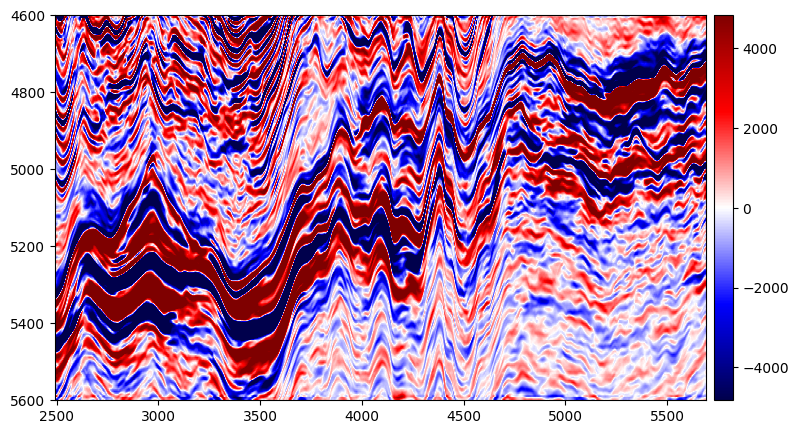

In [81]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))

c=ax.imshow(m_relative[1600 - il_start,:,:].T, aspect='auto', cmap='seismic',vmin=-0.1*m_relative.max(), vmax=0.1*m_relative.max(), #<---------------------- Escolha a Inline substituindo zero por um indice valido
            extent=[xl_start, xl_end, t[int(5600/dt)], t[int(4600/dt)]])
plt.colorbar(c, ax=ax, pad=0.01)
#ax.set_xlim(4000, 7000)
plt.grid(False)
#ax.set_ylim(6000, 4500)

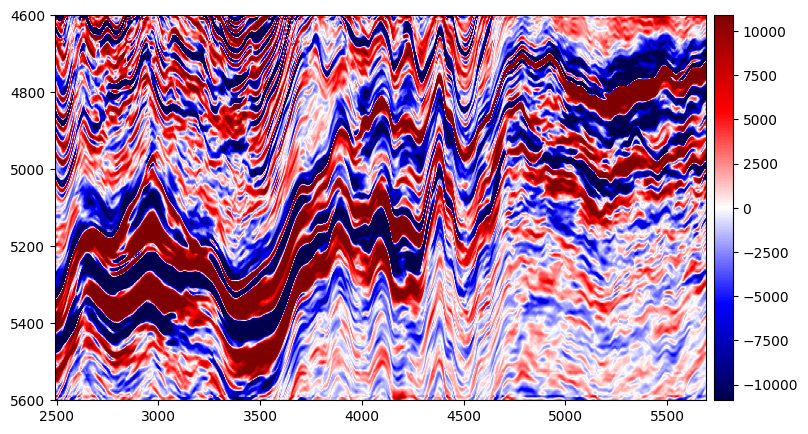

In [109]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))

c=ax.imshow(m_lsqr_relative[: , :, 1600 - il_start], aspect='auto', cmap='seismic', vmin=-0.1*m_lsqr_relative.max(), vmax=0.1*m_lsqr_relative.max(), #<---------------------- Escolha a Inline substituindo zero por um indice valido
            extent=[xl_start, xl_end, t[int(5600/dt)], t[int(4600/dt)]])
plt.colorbar(c, ax=ax, pad=0.01)
#ax.set_xlim(4000, 7000)
plt.grid(False)
#ax.set_ylim(6000, 4500)

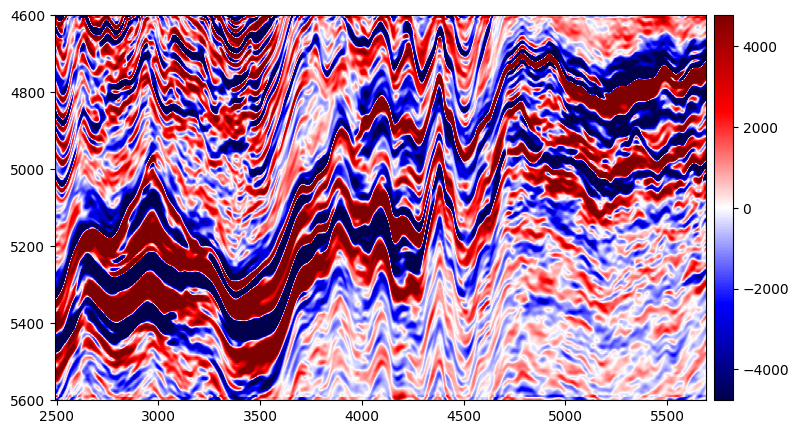

In [82]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))

c=ax.imshow(m_relative_reg[1600 - il_start, :, :].T, aspect='auto', cmap='seismic', vmin=-0.1*m_relative_reg.max(), vmax=0.1*m_relative_reg.max(), #<---------------------- Escolha a Inline substituindo zero por um indice valido
            extent=[xl_start, xl_end, t[int(5600/dt)], t[int(4600/dt)]])
plt.colorbar(c, ax=ax, pad=0.01)
#ax.set_xlim(4000, 7000)
plt.grid(False)
#ax.set_ylim(6000, 4500)

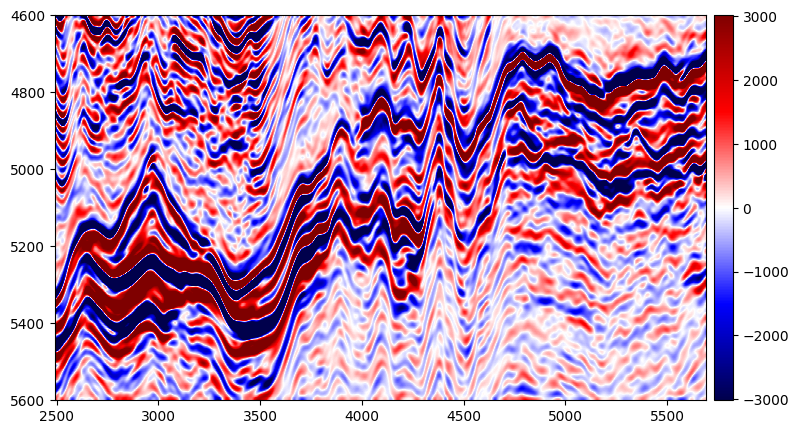

In [26]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))

c=ax.imshow(m_blocky[1600 - il_start, :, :].T, aspect='auto', cmap='seismic', vmin=-0.1*m_blocky.max(), vmax=0.1*m_blocky.max(), #<---------------------- Escolha a Inline substituindo zero por um indice valido
            extent=[xl_start, xl_end, t[int(5600/dt)], t[int(4600/dt)]])
plt.colorbar(c, ax=ax, pad=0.01)
#ax.set_xlim(4000, 7000)
plt.grid(False)
#ax.set_ylim(6000, 4500)